In [50]:
import pandas as pd
import numpy as np
from tslearn.neighbors import KNeighborsTimeSeries
from tslearn.clustering import TimeSeriesKMeans, silhouette_score
from tslearn.svm import TimeSeriesSVC
import shap
import wandb
import tsai.all
import imblearn
from tqdm import tqdm
import time
from IPython.display import clear_output

### Prepare Train & Valid dataframes

In [2]:
%run ../shared_functions.py
%run ../my_shared_functions.py
DIR_INPUT = '../../fraud-detection-handbook/simulated-data-transformed/data/'

END_DATE = "2018-09-14"

print("Load  files")
%time transactions_df=read_from_files(DIR_INPUT, "2018-06-11", END_DATE)
print("{0} transactions loaded, containing {1} fraudulent transactions".format(len(transactions_df),transactions_df.TX_FRAUD.sum()))

output_feature="TX_FRAUD"

input_features=['TX_AMOUNT','TX_DURING_WEEKEND', 'TX_DURING_NIGHT', 'CUSTOMER_ID_NB_TX_1DAY_WINDOW',
       'CUSTOMER_ID_AVG_AMOUNT_1DAY_WINDOW', 'CUSTOMER_ID_NB_TX_7DAY_WINDOW',
       'CUSTOMER_ID_AVG_AMOUNT_7DAY_WINDOW', 'CUSTOMER_ID_NB_TX_30DAY_WINDOW',
       'CUSTOMER_ID_AVG_AMOUNT_30DAY_WINDOW', 'TERMINAL_ID_NB_TX_1DAY_WINDOW',
       'TERMINAL_ID_RISK_1DAY_WINDOW', 'TERMINAL_ID_NB_TX_7DAY_WINDOW',
       'TERMINAL_ID_RISK_7DAY_WINDOW', 'TERMINAL_ID_NB_TX_30DAY_WINDOW',
       'TERMINAL_ID_RISK_30DAY_WINDOW']

BEGIN_DATE = "2018-08-08"
start_date_training = datetime.datetime.strptime(BEGIN_DATE, "%Y-%m-%d")
delta_train=7
delta_delay=7
delta_test=7


delta_valid = delta_test

(train_df, valid_df)=get_train_test_set(transactions_df,start_date_training,
                                       delta_train=delta_train,delta_delay=delta_delay,delta_test=delta_test)

SEQ_LEN = 5
seq_len = 5

# By default, scales input data
(train_df, valid_df)=scaleData(train_df, valid_df,input_features)

if torch.cuda.is_available():
    DEVICE = "cuda" 
else:
    DEVICE = "cpu"
print("Selected device is",DEVICE)

SEED = 42
seed_everything(SEED)

Load  files
CPU times: total: 422 ms
Wall time: 845 ms
919767 transactions loaded, containing 8195 fraudulent transactions
Selected device is cuda


<Figure size 640x480 with 0 Axes>

### PyTorch Handbook Prep

#### Datasets & DataLoaders

In [25]:
def pytorch_model_input_preparation(batch_size=64):
    x_train = torch.FloatTensor(train_df[input_features].values)
    x_valid = torch.FloatTensor(valid_df[input_features].values)
    y_train = torch.FloatTensor(train_df[output_feature].values)
    y_valid = torch.FloatTensor(valid_df[output_feature].values)

    training_set = FraudSequenceDataset(x_train, 
                                        y_train,train_df['CUSTOMER_ID'].values, 
                                        train_df['TX_DATETIME'].values,
                                        seq_len,
                                        padding_mode = "zeros")

    valid_set = FraudSequenceDataset(x_valid, 
                                    y_valid,
                                    valid_df['CUSTOMER_ID'].values, 
                                    valid_df['TX_DATETIME'].values,
                                    seq_len,
                                    padding_mode = "zeros")

    training_generator, valid_generator = prepare_generators(training_set, valid_set, batch_size=batch_size)

    return training_set, valid_set, training_generator, valid_generator

torch_train_set, torch_valid_set, torch_train_generator, torch_valid_generator = pytorch_model_input_preparation()

# validation dataset and generator have different shapes when more than 1 sample is accessed
# but when accessing only 1 sample, they have the same shape
print(
    torch_valid_set[:10][0].shape,
    next(iter(torch_valid_generator))[0][:10].shape,
    torch_valid_set[0][0].shape == next(iter(torch_valid_generator))[0][0].shape
)

torch.Size([5, 10, 15]) torch.Size([10, 15, 5]) True


#### List of covered models and load weights

In [4]:
# side note: retrieving metadata from the artifact doesn't work, empty dict is returned

handbook_torch_models = [
    { # 0
        'artifact_type': 'cnn',
        'artifact_name': 'cnn:v1',
        'artifact_path': 'cnn-v1/cnn_model.pt',
        'model_instance': FraudConvNet(len(input_features), seq_len).to(DEVICE)
    },
    { # 1
        'artifact_type': 'lstm',
        'artifact_name': 'lstm:v1',
        'artifact_path': 'lstm-v1/lstm_model.pt',
        'model_instance': FraudLSTM(len(input_features)).to(DEVICE)
    },
    { # 2
        'artifact_type': 'lstm',
        'artifact_name': 'lstm_attention:v1',
        'artifact_path': 'lstm_attention-v1/lstm_attention_model.pt',
        'model_instance': FraudLSTMWithAttention(len(input_features)).to(DEVICE)
    },
    { # 3
        'artifact_type': 'cnn',
        'artifact_name': 'cnn_hypertuned:v1',
        'artifact_path': 'cnn_hypertuned-v1/cnn_hypertuned_model.pt',
        'model_instance': FraudConvNetWithDropout(len(input_features), hidden_size=500, conv2_params=(100,2), p=0.2).to(DEVICE)
    },
    { # 4
        'artifact_type': 'lstm_hypertuned',
        'artifact_name': 'lstm_hypertuned:v1',
        'artifact_path': 'lstm_hypertuned-v1/lstm_hypertuned_model.pt',
        'model_instance': FraudLSTM(len(input_features), hidden_size=500, dropout_lstm=0.2).to(DEVICE)
    },
    { # 5
        'artifact_type': 'lstm_attention_hypertuned',
        'artifact_name': 'lstm_attention_hypertuned:v1',
        'artifact_path': 'lstm_attention_hypertuned-v1/lstm_attention_hypertuned_model.pt',
        'model_instance': FraudLSTMWithAttention(len(input_features), hidden_size=500, dropout_lstm=0.2).to(DEVICE)
    },
]

In [23]:
torch_model_index = 1

run = wandb.init()
artifact = run.use_artifact(f'mgr-anomaly-tsxai/mgr-anomaly-tsxai-project/{handbook_torch_models[torch_model_index]["artifact_name"]}',
                            type=handbook_torch_models[torch_model_index]['artifact_type'])
artifact_dir = artifact.download()
torch_model = handbook_torch_models[torch_model_index]['model_instance']
torch_model.load_state_dict(torch.load(f'artifacts/{handbook_torch_models[torch_model_index]["artifact_path"]}'))
torch_model.eval()

wandb:   1 of 1 files downloaded.  


FraudLSTM(
  (lstm): LSTM(15, 100, batch_first=True)
  (fc1): Linear(in_features=100, out_features=100, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=100, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

#### Get predictions

In [26]:
torch_valid_predictions = get_predictions_sequential(torch_model, torch_valid_generator)
torch_valid_predictions_int = np.round(torch_valid_predictions).astype(int)
torch_valid_predictions_int

array([0, 0, 0, ..., 0, 0, 0])

#### Prepare inliers & outliers based on model output

In [28]:
# set output to false to ease access to particular inliers/outliers
torch_valid_set.output = False
predicted_inliers_torch = torch_valid_set.features[torch_valid_set.sequences_ids[torch_valid_predictions_int == 0],:]
predicted_outliers_torch = torch_valid_set.features[torch_valid_set.sequences_ids[torch_valid_predictions_int == 1],:]
torch_valid_set.output = True
# for the testing purpose of this notebook, only subset of outliers is used
predicted_outliers_torch_sample = predicted_outliers_torch[:10]
print(predicted_inliers_torch.shape)
print(predicted_outliers_torch.shape)
print(predicted_outliers_torch_sample.shape)

torch.Size([58069, 5, 15])
torch.Size([268, 5, 15])
torch.Size([10, 5, 15])


### TSAI Prep

#### List of covered models and load weights

In [29]:
# models with best results from Sweeps have not been trained (yet?)

tsai_models = [
    { # 0
        'artifact_type': 'model',
        'artifact_name': 'lstm_fit_one_cycle:v0',
        'artifact_path': 'lstm_fit_one_cycle-v0/lstm_fit_one_cycle.pth',
        'model_instance': tsai.all.LSTM(
            c_in=len(input_features),
            c_out=1
        ).to(DEVICE),
        'batch_size': 64
    },
    { # 1
        'artifact_type': 'model',
        'artifact_name': 'fcn_fit_one_cycle:v0',
        'artifact_path': 'fcn_fit_one_cycle-v0/fcn_fit_one_cycle.pth',
        'model_instance': tsai.all.FCN(
            c_in=len(input_features),
            c_out=1
        ).to(DEVICE),
        'batch_size': 64
    },
    { # 2
        'artifact_type': 'model',
        'artifact_name': 'gmlp_fit_one_cycle:v0',
        'artifact_path': 'gmlp_fit_one_cycle-v0/gmlp_fit_one_cycle.pth',
        'model_instance': tsai.all.gMLP(
            c_in=len(input_features),
            c_out=1,
            seq_len=SEQ_LEN
        ).to(DEVICE),
        'batch_size': 64
    },
    { # 3
        'artifact_type': 'model',
        'artifact_name': 'gru_fcn_fit_one_cycle:v0',
        'artifact_path': 'gru_fcn_fit_one_cycle-v0/gru_fcn_fit_one_cycle.pth',
        'model_instance': tsai.all.GRU_FCN(
            c_in=len(input_features),
            c_out=1,
            seq_len=SEQ_LEN
        ).to(DEVICE),
        'batch_size': 64
    },
    { # 4
        'artifact_type': 'model',
        'artifact_name': 'gru_fit_one_cycle:v0',
        'artifact_path': 'gru_fit_one_cycle-v0/gru_fit_one_cycle.pth',
        'model_instance': tsai.all.GRU(
            c_in=len(input_features),
            c_out=1
        ).to(DEVICE),
        'batch_size': 64
    },
    { # 5
        'artifact_type': 'model',
        'artifact_name': 'inceptiontime_fit_one_cycle:v0',
        'artifact_path': 'inceptiontime_fit_one_cycle-v0/inceptiontime_fit_one_cycle.pth',
        'model_instance': tsai.all.InceptionTime(
            c_in=len(input_features),
            c_out=1,
            seq_len=SEQ_LEN
        ).to(DEVICE),
        'batch_size': 64
    },
    { # 6
        'artifact_type': 'model',
        'artifact_name': 'lstm_fcn_fit_one_cycle:v1',
        'artifact_path': 'lstm_fcn_fit_one_cycle-v1/lstm_fcn_fit_one_cycle.pth',
        'model_instance': tsai.all.LSTM_FCN(
            c_in=len(input_features),
            c_out=1,
            seq_len=SEQ_LEN
        ).to(DEVICE),
        'batch_size': 64
    },
    { # 7
        'artifact_type': 'model',
        'artifact_name': 'mlstm_fcn_fit_one_cycle:v0',
        'artifact_path': 'mlstm_fcn_fit_one_cycle-v0/mlstm_fcn_fit_one_cycle.pth',
        'model_instance': tsai.all.MLSTM_FCN(
            c_in=len(input_features),
            c_out=1,
            seq_len=SEQ_LEN
        ).to(DEVICE),
        'batch_size': 64
    },
    { # 8
    # RuntimeError: Error(s) in loading state_dict for mWDN:
	# Missing key(s) in state_dict: "blocks.2.mWDN_H.weight", "blocks.2.mWDN_H.bias", "blocks.2.mWDN_L.weight", "blocks.2.mWDN_L.bias". 
        'artifact_type': 'model',
        'artifact_name': 'mwdn_fit_one_cycle:v2',
        'artifact_path': 'mwdn_fit_one_cycle-v2/mwdn_fit_one_cycle.pth',
        'model_instance': tsai.all.mWDN(
            c_in=len(input_features),
            c_out=1,
            seq_len=SEQ_LEN,
            base_arch=tsai.all.InceptionTime
        ).to(DEVICE),
        'batch_size': 64
    },
    { # 9
        'artifact_type': 'model',
        'artifact_name': 'omniscalecnn_fit_one_cycle:v1',
        'artifact_path': 'omniscalecnn_fit_one_cycle-v1/omniscalecnn_fit_one_cycle.pth',
        'model_instance': tsai.all.OmniScaleCNN(
            c_in=len(input_features),
            c_out=1,
            seq_len=SEQ_LEN
        ).to(DEVICE),
        'batch_size': 64
    },
    { # 10
        'artifact_type': 'model',
        'artifact_name': 'rescnn_fit_one_cycle:v1',
        'artifact_path': 'rescnn_fit_one_cycle-v1/rescnn_fit_one_cycle.pth',
        'model_instance': tsai.all.ResCNN(
            c_in=len(input_features),
            c_out=1
        ).to(DEVICE),
        'batch_size': 64
    },
    { # 11
        'artifact_type': 'model',
        'artifact_name': 'resnet_fit_one_cycle:v0',
        'artifact_path': 'resnet_fit_one_cycle-v0/resnet_fit_one_cycle.pth',
        'model_instance': tsai.all.ResNet(
            c_in=len(input_features),
            c_out=1
        ).to(DEVICE),
        'batch_size': 64
    },
    { # 12
        'artifact_type': 'model',
        'artifact_name': 'tsit_fit_one_cycle:v0',
        'artifact_path': 'tsit_fit_one_cycle-v0/tsit_fit_one_cycle.pth',
        'model_instance': tsai.all.TSiT(
            c_in=len(input_features),
            c_out=1,
            seq_len=SEQ_LEN,
            use_token=False
        ).to(DEVICE),
        'batch_size': 64
    },
    { # 13
        # 1. requires batch size of 16, otherwise with default 64 OOM is raised
        # 2. ~40 min prediction execution time
        # 3. don't use, results are really weak for this one (AP=0.283, F1=0.204)
        'artifact_type': 'model',
        'artifact_name': 'tsperceiver_fit_one_cycle:v0',
        'artifact_path': 'tsperceiver_fit_one_cycle-v0/tsperceiver_fit_one_cycle.pth',
        'model_instance': tsai.all.TSPerceiver(
            c_in=len(input_features),
            c_out=1,
            seq_len=SEQ_LEN
        ).to(DEVICE),
        'batch_size': 16
    },
    { # 14
        'artifact_type': 'model',
        'artifact_name': 'tst_fit_one_cycle:v0',
        'artifact_path': 'tst_fit_one_cycle-v0/tst_fit_one_cycle.pth',
        'model_instance': tsai.all.TST(
            c_in=len(input_features),
            c_out=1,
            seq_len=SEQ_LEN
        ).to(DEVICE),
        'batch_size': 64
    },
    { # 15
        'artifact_type': 'model',
        'artifact_name': 'xcm_fit_one_cycle:v0',
        'artifact_path': 'xcm_fit_one_cycle-v0/xcm_fit_one_cycle.pth',
        'model_instance': tsai.all.XCM(
            c_in=len(input_features),
            c_out=1,
            seq_len=SEQ_LEN
        ).to(DEVICE),
        'batch_size': 64
    },
    { # 16
        # weak results (AP=0.292, F1=0.259)
        'artifact_type': 'model',
        'artifact_name': 'transformermodel_fit_one_cycle:v0',
        'artifact_path': 'transformermodel_fit_one_cycle-v0/transformermodel_fit_one_cycle.pth',
        'model_instance': tsai.all.TransformerModel(
            c_in=len(input_features),
            c_out=1
        ).to(DEVICE),
        'batch_size': 64
    },
    { # 17
        'artifact_type': 'model',
        'artifact_name': 'tst_fit_one_cycle:v0',
        'artifact_path': 'tst_fit_one_cycle-v0/tst_fit_one_cycle.pth',
        'model_instance': tsai.all.TST(
            c_in=len(input_features),
            c_out=1,
            seq_len=SEQ_LEN
        ).to(DEVICE),
        'batch_size': 64
    },
]

In [30]:
tsai_model_index = 0

run = wandb.init()
artifact = run.use_artifact(f'mgr-anomaly-tsxai/mgr-anomaly-tsxai-project/{tsai_models[tsai_model_index]["artifact_name"]}',
                            type=tsai_models[tsai_model_index]['artifact_type'])
artifact_dir = artifact.download()
tsai_model = tsai_models[tsai_model_index]['model_instance']
tsai_model.load_state_dict(torch.load(f'artifacts/{tsai_models[tsai_model_index]["artifact_path"]}'))
tsai_model.eval()

wandb:   1 of 1 files downloaded.  


LSTM(
  (rnn): LSTM(15, 100, batch_first=True)
  (dropout): Identity()
  (fc): Linear(in_features=100, out_features=1, bias=True)
)

#### Datasets & DataLoaders

In [31]:
def tsai_model_input_preparation(batch_size=64):
    x_train, y_train = prepare_sequenced_X_y(train_df, SEQ_LEN, input_features, output_feature)
    x_valid, y_valid = prepare_sequenced_X_y(valid_df, SEQ_LEN, input_features, output_feature)
    X, y, splits = tsai.all.combine_split_data([x_train.numpy(), x_valid.numpy()], [y_train.numpy(), y_valid.numpy()])
    dsets = tsai.all.TSDatasets(X, y, splits=splits, inplace=True)
    dls = tsai.all.TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=batch_size, drop_last=False, device='cuda')
    return dsets, dls

tsai_dsets, tsai_dls = tsai_model_input_preparation(tsai_models[tsai_model_index]['batch_size'])

#### Get predictions

In [32]:
tsai_valid_predictions_logits = get_predictions_sequential(tsai_model, tsai_dls.valid)
tsai_valid_predictions = torch.nn.Sigmoid()(torch.FloatTensor(tsai_valid_predictions_logits)).numpy()
tsai_valid_predictions_int = np.round(tsai_valid_predictions).astype(int)
tsai_valid_predictions_int

array([0, 0, 0, ..., 0, 0, 0])

#### Prepare inliers & outliers based on model output

In [33]:
predicted_inliers_tsai = tsai_dls.valid.dataset[tsai_valid_predictions_int == 0][0]
predicted_outliers_tsai = tsai_dls.valid.dataset[tsai_valid_predictions_int == 1][0]
predicted_inliers_tsai = predicted_inliers_tsai.reshape(predicted_inliers_tsai.shape[0], predicted_inliers_tsai.shape[2],
                                                        predicted_inliers_tsai.shape[1])
predicted_outliers_tsai = predicted_outliers_tsai.reshape(predicted_outliers_tsai.shape[0], predicted_outliers_tsai.shape[2],
                                                          predicted_outliers_tsai.shape[1])
predicted_outliers_tsai_sample = predicted_outliers_tsai[:10]
print(predicted_inliers_tsai.shape)
print(predicted_outliers_tsai.shape)
print(predicted_outliers_tsai_sample.shape)

torch.Size([58091, 5, 15])
torch.Size([246, 5, 15])
torch.Size([10, 5, 15])


### Time Series COIN

#### The main algorithm and supporting functions

In [96]:
def get_context(outlier, nearest_neighbors, inliers):
    neighbors_index = nearest_neighbors.kneighbors([outlier], return_distance=False).tolist()[0]
    return inliers[neighbors_index]

def replicate_upsampling(outlier, context):
    return np.array([outlier for _ in range(len(context))])

def synthetic_upsampling(C_i_l, o_i, trim_small_values=True): # C_i_l.shape = (x, 5, 15), o_i.shape = (5, 15)
    # transformation matrix for synthetic sampling
    num_c0_new = C_i_l.shape[0] - 1
    coeff_c0_new = np.random.rand(num_c0_new, C_i_l.shape[0]) 

    # use knn to find the closest distance between the outlier and its context
    nbrs_local = KNeighborsTimeSeries(n_neighbors=1).fit(C_i_l) 
    min_dist_to_nbr = nbrs_local.kneighbors([o_i])[0][0, 0]
    min_dist_to_nbr /= C_i_l.shape[2] # normalize distance

    # normalize each row of the coeff_c0_new array so that the sum of each row is equal to 1
    for r in range(coeff_c0_new.shape[0]):
        coeff_c0_new[r, :] /= sum(coeff_c0_new[r, :])

    # flatten last 2 dims of C_i_l otherwise it is impossible to receive insts_c0_new with
    # (cluster_length - 1, 5, 15) shape out of dot product where C_i_l.shape = (cluster_length, 5, 15)
    insts_c0_new = np.dot(coeff_c0_new,
                          C_i_l.reshape(-1, C_i_l.shape[1] * C_i_l.shape[2]) - np.dot(np.ones((C_i_l.shape[0], 1)), [o_i.flatten()]))

    for r in range(insts_c0_new.shape[0]):                      # shrink to prevent overlap
        insts_c0_new[r, :] *= (0.2 * np.random.rand(1)[0] * min_dist_to_nbr)
    insts_c0_new += np.dot(np.ones((num_c0_new, 1)), [o_i.flatten()])    # origin + shift

    if trim_small_values:
        insts_c0_new[insts_c0_new < 0.001] = 0

    # bring back the 3d shape
    insts_c0 = np.vstack(([o_i], insts_c0_new.reshape(-1, o_i.shape[0], o_i.shape[1])))        

    return insts_c0

def mixed_upsampling(C_i_l, o_i, trim_small_values=True, minimal_outlier_num=4):
    # use ts coin sampling to generate outliers
    O_i_l = synthetic_upsampling(C_i_l, o_i, trim_small_values=trim_small_values)
    # context length must be bigger than number of outliers before SMOTE, otherwise ValueError is raised
    minimal_outlier_num = min(minimal_outlier_num, C_i_l.shape[0] - 1)
    # select minimal number of outliers and include the original outlier at index 0
    outliers_subset = O_i_l[:minimal_outlier_num]
    
    # side note: shrinkage parameter in RandomOversampler does not influence upsampled outliers values
    #
    # k_neighbors must be set to minimal_outlier_num - 1, otherwise ValueError during fit_resample is raised
    ROS = imblearn.over_sampling.SMOTE(sampling_strategy=1, k_neighbors=minimal_outlier_num - 1)
    X = np.vstack((outliers_subset.reshape(-1, outliers_subset.shape[1] * outliers_subset.shape[2]), C_i_l.reshape(-1, C_i_l.shape[1] * C_i_l.shape[2])))
    y = np.hstack((
        np.ones((1, outliers_subset.shape[0])),
        np.zeros((1, C_i_l.shape[0]))
    )).T
    X_resampled, Y_resampled = ROS.fit_resample(X, y) # X has to be 2d
    O_i_indices = [i for i in range(len(Y_resampled)) if Y_resampled[i] == 1]
    return X_resampled.reshape(-1, C_i_l.shape[1], C_i_l.shape[2])[O_i_indices]

def cluster(C_i, increase_cluster_num=True):
    # https://github.com/tslearn-team/tslearn/issues/278
    # kmeans = TimeSeriesKMeans(n_clusters=2, n_init=10, metric='dtw').fit(C_i)

    # n_init=10 => computation takes much more time, for 1000 inliers, 10 outliers and [2, 7] n_clusters
    # search, it takes around 1min 40 seconds while for default n_init it takes around 15 seconds
    # 
    # result is the same for both n_init values, silhoutte score always favors 2 clusters
    # there's no point in using n_init=10 

    kmeans = TimeSeriesKMeans(n_clusters=2, metric='dtw').fit(C_i)
    best_silhouette_score = silhouette_score(C_i, kmeans.predict(C_i), metric='dtw')
    L = 2
    for n in range(3, 6):
        new_kmeans = TimeSeriesKMeans(n_clusters=n, metric='dtw').fit(C_i)
        new_silhouette_score = silhouette_score(C_i, kmeans.predict(C_i), metric='dtw')
        if new_silhouette_score > best_silhouette_score:
            best_silhouette_score = new_silhouette_score
            kmeans = new_kmeans
            L = n

    if increase_cluster_num:
        L += 1

    C_i_l = np.array([C_i[kmeans.labels_ == i] for i in range(L)])
    return C_i_l    

def abandon_small_clusters(clustered, not_clustered, ratio):
    return np.array([cluster_i for cluster_i in clustered if len(cluster_i) >= ratio * len(not_clustered)])

def create_local_classifier(C_i_l, O_i_l):
    clf = TimeSeriesSVC(kernel='linear', random_state=SEED, gamma=1.) # kernel='gak'
    X = np.vstack((C_i_l, O_i_l))
    y = np.hstack((np.zeros(C_i_l.shape[0]), np.ones(O_i_l.shape[0])))
    clf.fit(X, y)
    return clf

def calculate_all_abnormal_attribute_scores(context_results):
    # LinearTimeSeriesSVC has 75 weights, 1 weight per feature for all sequence elements
    abnormal_attribute_scores = np.zeros(context_results[0]['clf'].svm_estimator_.coef_[0].shape) # each "context cluster's" cluster returns the same shape
    for context_cluster_results in context_results:
        abnormal_attribute_scores += len(context_cluster_results['context_cluster']) * \
            np.abs(context_cluster_results['clf'].svm_estimator_.coef_[0])
    abnormal_attribute_scores /= np.sum([len(context_result['context_cluster']) for context_result in context_results])
    abnormal_attribute_scores /= np.sum(abnormal_attribute_scores)
    return abnormal_attribute_scores

def calculate_outlierness_score(context_results, outlier):
    outlierness_score = 0
    for context_cluster_results in context_results:
        # missing coef_ in the implementation of TimeSeriesSVC, where documentation suggests that coef_ should be present
        # https://github.com/tslearn-team/tslearn/issues/447
        # using svm_estimator_.coef_ instead of coef_ as suggested in the issue above

        # decision_function will return probability instead on int label
        outlierness_score_cluster = abs(context_cluster_results['clf'].decision_function(outlier)) /\
            np.linalg.norm(context_cluster_results['clf'].svm_estimator_.coef_[0], ord=2)
        outlierness_score += np.linalg.norm(len(context_cluster_results['context_cluster']) * outlierness_score_cluster * \
            context_cluster_results['clf'].svm_estimator_.coef_[0] / np.linalg.norm(context_cluster_results['clf'].svm_estimator_.coef_[0]))
    outlierness_score /= sum([len(context_result['context_cluster']) for context_result in context_results])
    return outlierness_score

def tscoin(inliers, outliers, upsampling_technique='synthetic', abandon_ratio=0.05):
    context_neighbors = int(np.sqrt(len(inliers)))
    nearest_neighbors = KNeighborsTimeSeries(n_neighbors=context_neighbors, metric='dtw', n_jobs=-1) #  metric='euclidean'
    # n_jobs=-1 doesn't seem to decrease execution time
    start_time=time.time()
    nearest_neighbors = nearest_neighbors.fit(inliers) # array of shape (n_ts, sz, d) <=> (num_samples, seq_len, num_features)
    end_time = time.time()
    print(f'KNeighbors fitting time: {round(end_time - start_time, 2)} seconds')
    outlierness_score_list = []
    abnormal_attributes_scores_list = []
    for o_i in outliers:
        C_i = get_context(o_i, nearest_neighbors, inliers)
        C_i_clusters = cluster(C_i)
        C_i_clusters = abandon_small_clusters(C_i_clusters, C_i, abandon_ratio)
        context_results = []
        for C_i_l in C_i_clusters:
            if upsampling_technique == 'synthetic':
                O_i_l = synthetic_upsampling(C_i_l, o_i)
            elif upsampling_technique == 'replicate':
                O_i_l = replicate_upsampling(o_i, C_i_l)
            else:
                O_i_l = mixed_upsampling(C_i_l, o_i)
            clf = create_local_classifier(C_i_l, O_i_l)
            context_results.append({
                'clf': clf, 
                'context_cluster': C_i_l,
                'upsampled_outlier': O_i_l,
                }) 
        abnormal_attributes_scores = calculate_all_abnormal_attribute_scores(context_results)
        abnormal_attributes_scores_list.append(abnormal_attributes_scores)
        outlierness_score = calculate_outlierness_score(context_results, o_i.reshape(1, o_i.shape[0], o_i.shape[1]))
        outlierness_score_list.append(outlierness_score)
    return outlierness_score_list, abnormal_attributes_scores_list

# Regarding SHAP on local TimeSeriesSVC model:
#   * DeepExplainer works only with PyTorch & TF
#   * GradientExplainer works only with PyTorch & TF
#   * KernelExplainer accepts only 1d & 2d inputs, local model was trained on 3d inputs so error is raised if data is passed as 2d
#       ValueError: Dimensions of the provided timeseries(except first) must match those of the fitted data!
#       ((x, 5, 15) and (x, 75, 1) are passed shapes)

#### Test on PyTorch Handbook predictions

##### On 10 outliers -> outlierness scores should be high

In [ ]:
%%time

outlierness_score, abnormal_attributes_scores = tscoin(predicted_inliers_torch.numpy(), predicted_outliers_torch_sample.numpy())

outlierness_score

12.408704466404805
11.351009971855412
1.0431420667071014
7.707572965897579
11.37178479592137
9.447653018541835
9.175069379141423
1.2557810431207006
11.236914850074708
2.0983316281636557


In [101]:
np.mean(outlierness_score)

5.4695076105938405

##### On 10 inliers -> outlierness scores should be low

In [102]:
%%time

outlierness_score, abnormal_attributes_scores = tscoin(predicted_inliers_torch[10:].numpy(), predicted_inliers_torch[:10].numpy())

outlierness_score

KNeighbors fitting time: 55.39 seconds
CPU times: total: 4min 5s
Wall time: 4min 3s


[0.6350903112629652,
 0.2441303073415549,
 0.5065184834795009,
 0.2124197398052941,
 0.6104803678298522,
 0.21296435426264354,
 0.17398151687993962,
 0.4889372267863771,
 0.6367746213541445,
 0.17806747126157738]

In [103]:
np.mean(outlierness_score)

0.3899364400263849

#### Test on TSAI predictions

##### On 10 outliers -> outlierness scores should be high

In [105]:
%%time

outlierness_score, abnormal_attributes_scores = tscoin(predicted_inliers_tsai.numpy(), predicted_outliers_tsai_sample.numpy())

outlierness_score

KNeighbors fitting time: 21.43 seconds
CPU times: total: 3min 22s
Wall time: 3min 25s


[4.486946215518369,
 5.951699409777079,
 5.849572064810701,
 6.065453668319387,
 8.78131177111699,
 3.995344375793231,
 6.0860344776969395,
 5.383514730630193,
 5.801560896913764,
 2.893090768732446]

In [106]:
np.mean(outlierness_score)

5.52945283793091

##### On 10 inliers -> outlierness scores should be low

In [107]:
%%time

outlierness_score, abnormal_attributes_scores = tscoin(predicted_inliers_tsai[10:].numpy(), predicted_inliers_tsai[:10].numpy())

outlierness_score

KNeighbors fitting time: 18.69 seconds
CPU times: total: 3min 37s
Wall time: 3min 38s


[0.7674276672652643,
 0.23537568835657116,
 0.5245537721075307,
 0.3059322322210656,
 0.5756320414376048,
 0.30186248814900396,
 0.5464135283582413,
 0.4873703042314314,
 0.40956114817689704,
 0.18830366878435567]

In [108]:
np.mean(outlierness_score)

0.4342432539087966

### SHAP

#### Torch Handbook

##### Generate Shap values 

In [89]:
_, _, torch_shap_generator, _ = pytorch_model_input_preparation(1000)

start_time=time.time()

# explainer constructor expects data of shape order (x, num_features, seq_len) because model was trained on dataloader
# with such shape order

torch_model.train()
explainer = shap.DeepExplainer(torch_model, next(iter(torch_shap_generator))[0])

outliers_shap_values = []
for index in np.where(torch_valid_predictions_int == 1)[0]:
    clear_output(wait=True)
    torch_model.train()
    # explainer expects here 3d input shape (num_shap_observations, num_features, seq_len)
    shap_values = explainer.shap_values(torch_valid_set[index][0].reshape(1, len(input_features), seq_len))
    outliers_shap_values.append([index, shap_values])
    
torch_model.eval()

shap_values_generation_time = time.time()-start_time
print(f'Shap Values generation time: {round(shap_values_generation_time, 2)} seconds')

# generates a lot of "Warning: unrecognized nn.Module: LSTM" for LSTM

Shap Values generation time: 18.37 seconds


##### Pick 1 outlier for testing purposes

In [90]:
outlier_index = 0
selected_outlier_shap_values = outliers_shap_values[outlier_index][1][0]

##### Summary plot per timestep

t = 0
[ 0.02185917  0.00019755  0.00603454  0.00570004 -0.00026453  0.00459573
  0.00030033 -0.00154182  0.08139845 -0.0105191   0.00183082  0.00135759
 -0.00175457  0.00196271 -0.00134212]


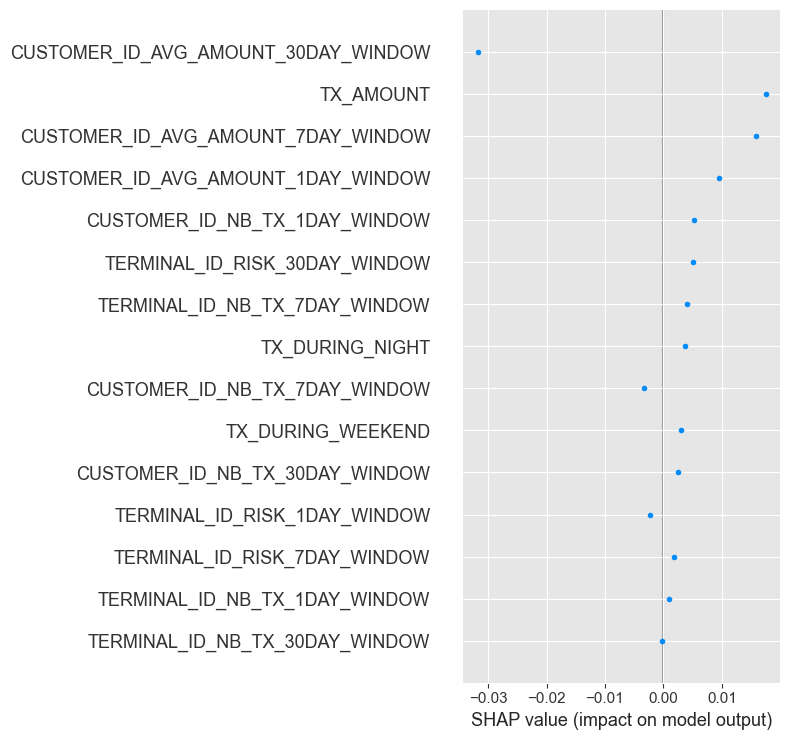

t = 1
[-0.03337505 -0.00222237  0.00266279 -0.00116008  0.00021986  0.00174237
 -0.00877205 -0.00307026  0.06692123 -0.00767069  0.00151175  0.01230132
 -0.00179086  0.02983143 -0.0006287 ]


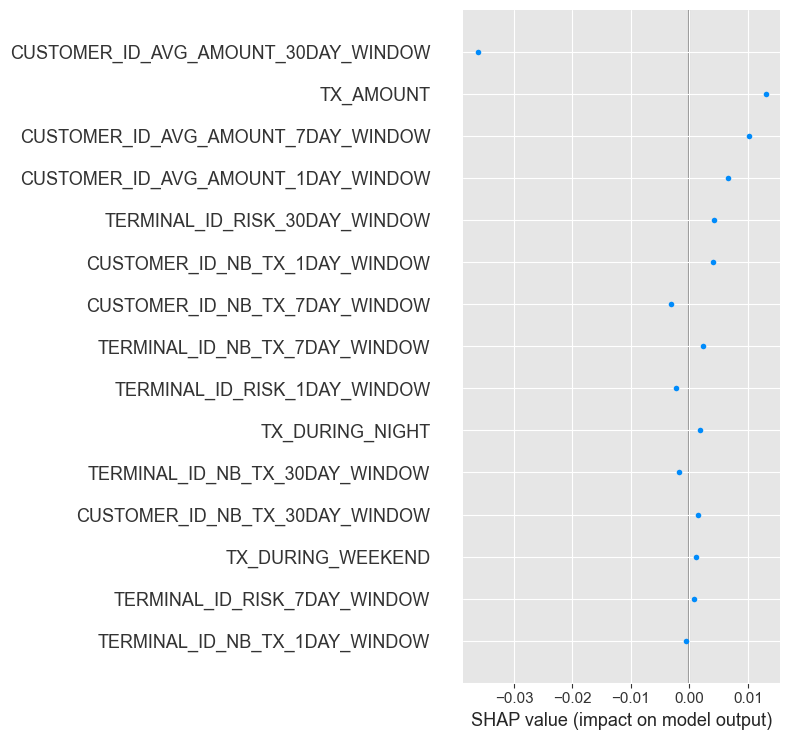

t = 2
[-1.46920430e-02 -2.79356260e-03 -1.35118060e-03  9.79736215e-05
  2.09462410e-03 -3.39547917e-03 -1.36040673e-02 -6.09842176e-03
  5.95060848e-02 -2.75334949e-03  1.04059302e-03 -3.80266807e-03
 -1.12099585e-03 -1.23419799e-02 -5.55739040e-04]


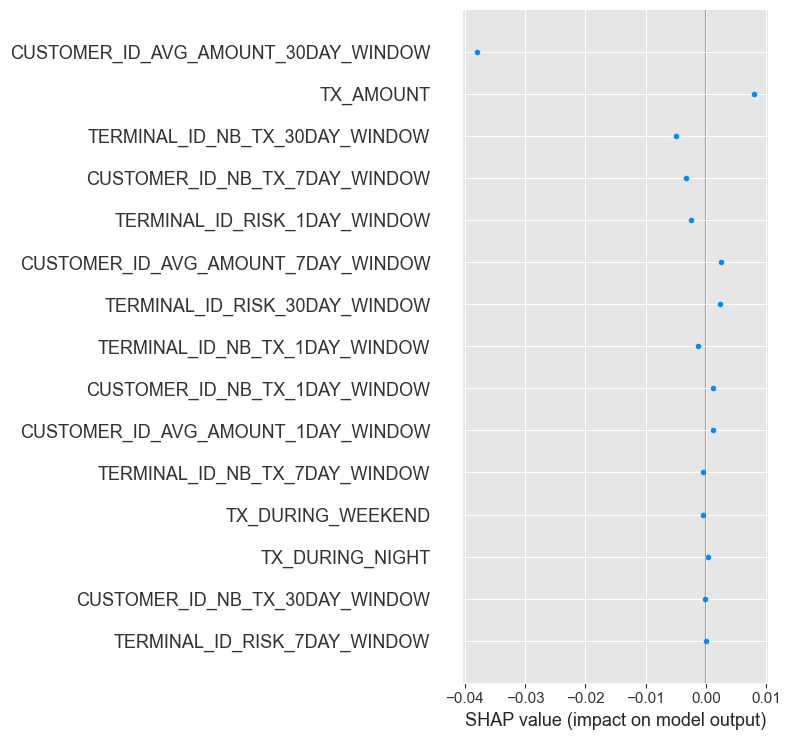

t = 3
[-0.01214333 -0.00218843 -0.00434912  0.00010825  0.01895753 -0.00833179
 -0.02109946 -0.01030038  0.07500323 -0.00022376  0.00067555 -0.00115786
 -0.00197178  0.01327501  0.00161911]


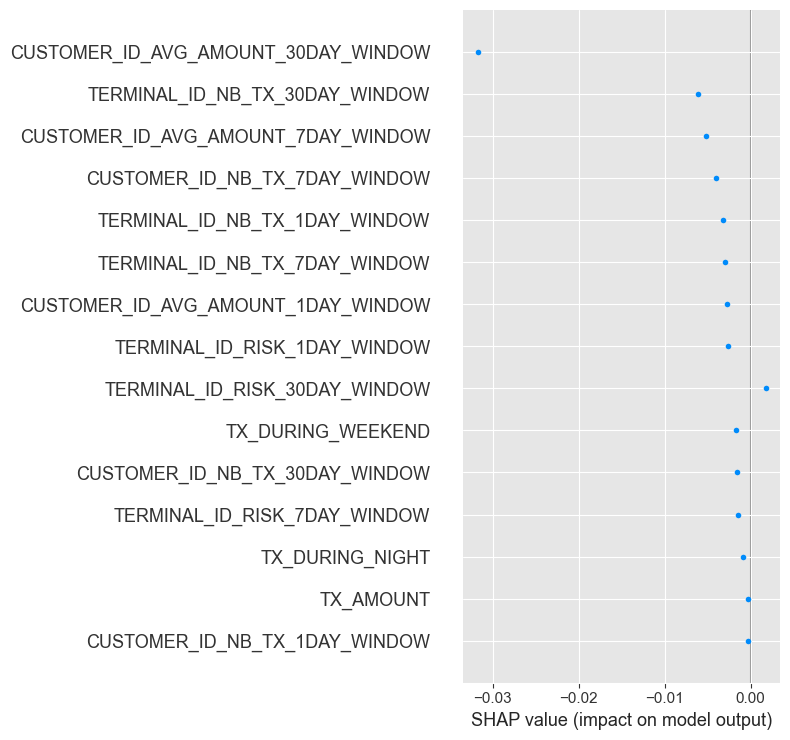

t = 4
[ 0.30072391 -0.00896082 -0.00193279  0.00055895 -0.00078762 -0.01142772
 -0.01231669  0.0005751   0.1404705   0.01274624 -0.00259712  0.01535784
 -0.01264631 -0.016312    0.00911699]


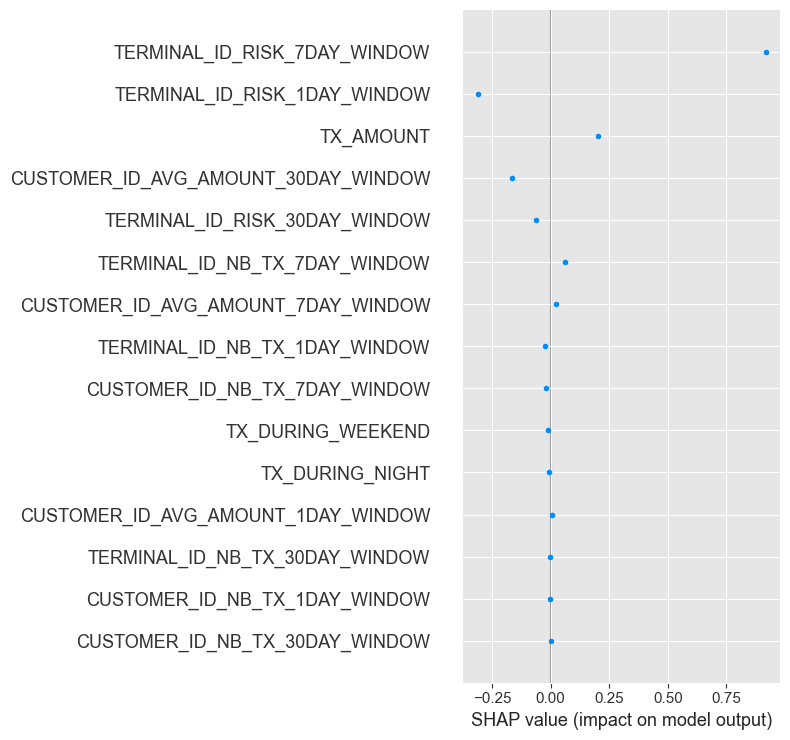

In [91]:
for t in range(seq_len):
    print('t =', t)
    print(np.array([el[t] for el in shap_values[0].tolist()]))
    shap.summary_plot(np.array([el[t] for el in selected_outlier_shap_values.tolist()]).reshape(1, -1),
                    feature_names=input_features)
    
# feature name - feature index mapping seems to be correct, unfortunately names per timestamp are not in the same order

##### Summary plot timesteps aggregated

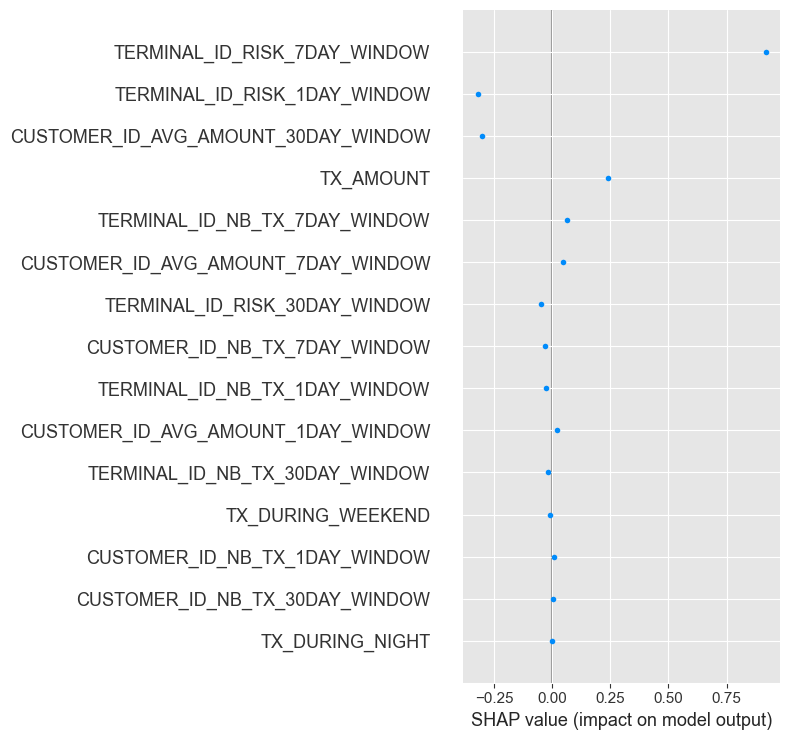

In [92]:
shap.summary_plot(np.sum(selected_outlier_shap_values, axis=1).reshape(1, -1),
                feature_names=input_features)

##### Force plot per timestep

t = 0
[ 0.02185917  0.00019755  0.00603454  0.00570004 -0.00026453  0.00459573
  0.00030033 -0.00154182  0.08139845 -0.0105191   0.00183082  0.00135759
 -0.00175457  0.00196271 -0.00134212]


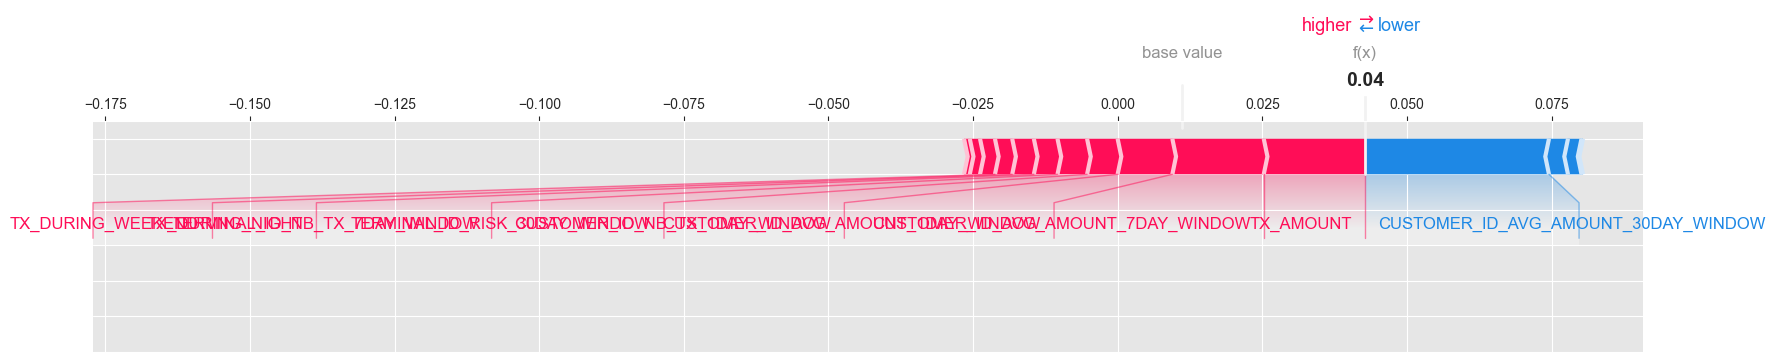

t = 1
[-0.03337505 -0.00222237  0.00266279 -0.00116008  0.00021986  0.00174237
 -0.00877205 -0.00307026  0.06692123 -0.00767069  0.00151175  0.01230132
 -0.00179086  0.02983143 -0.0006287 ]


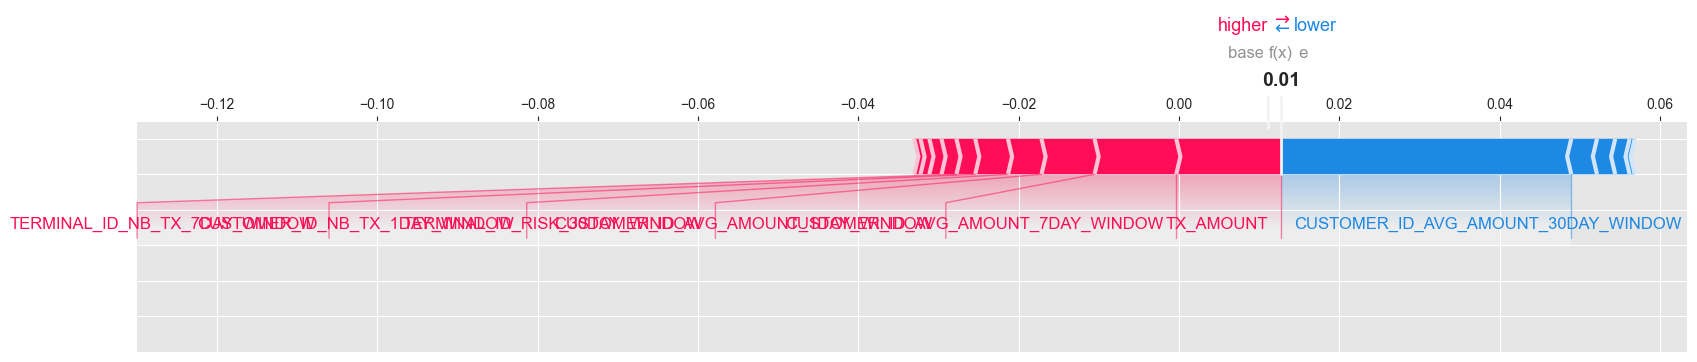

t = 2
[-1.46920430e-02 -2.79356260e-03 -1.35118060e-03  9.79736215e-05
  2.09462410e-03 -3.39547917e-03 -1.36040673e-02 -6.09842176e-03
  5.95060848e-02 -2.75334949e-03  1.04059302e-03 -3.80266807e-03
 -1.12099585e-03 -1.23419799e-02 -5.55739040e-04]


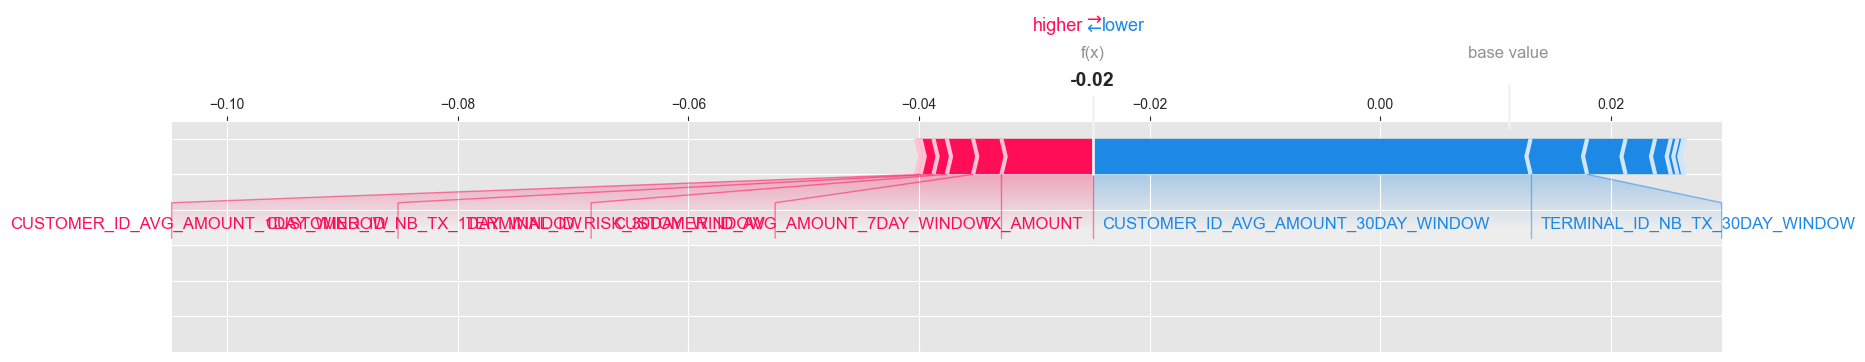

t = 3
[-0.01214333 -0.00218843 -0.00434912  0.00010825  0.01895753 -0.00833179
 -0.02109946 -0.01030038  0.07500323 -0.00022376  0.00067555 -0.00115786
 -0.00197178  0.01327501  0.00161911]


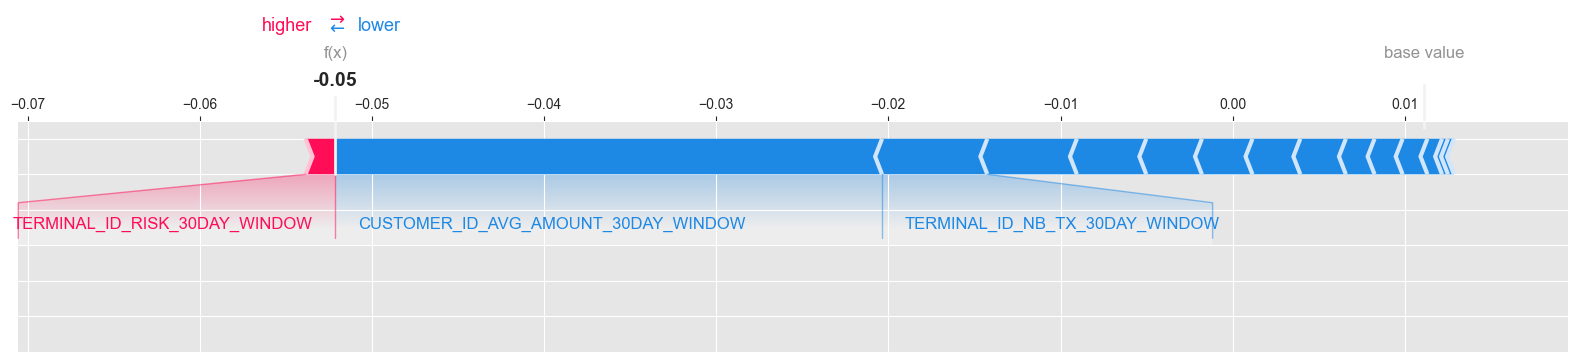

t = 4
[ 0.30072391 -0.00896082 -0.00193279  0.00055895 -0.00078762 -0.01142772
 -0.01231669  0.0005751   0.1404705   0.01274624 -0.00259712  0.01535784
 -0.01264631 -0.016312    0.00911699]


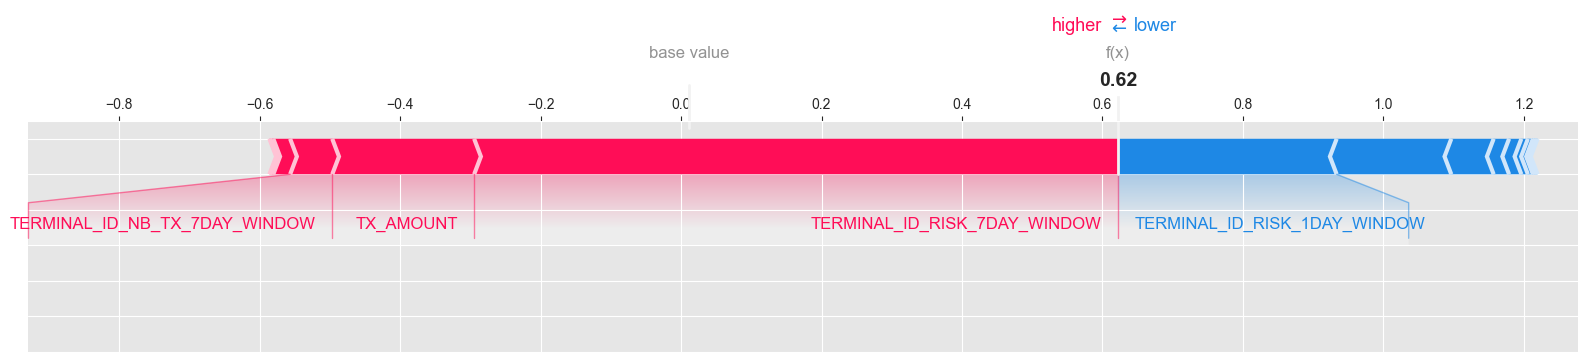

In [93]:
for t in range(seq_len):
    print('t =', t)
    print(np.array([el[t] for el in shap_values[0].tolist()]))
    shap.plots.force(explainer.expected_value[0],
                    np.array([el[t] for el in selected_outlier_shap_values.tolist()]),
                    feature_names=input_features,
                    matplotlib=True,
                    )   

##### Force plot timesteps aggregated

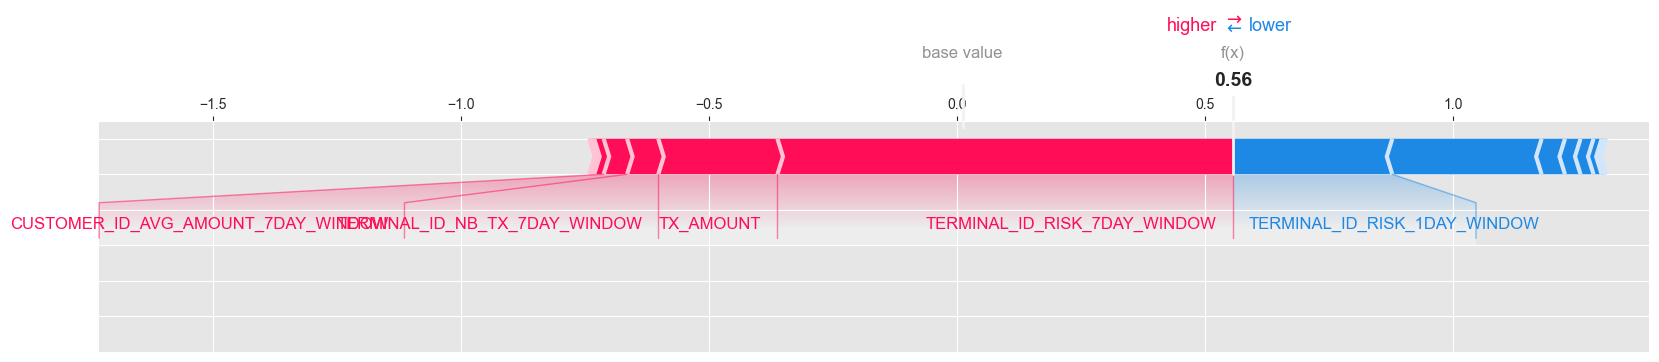

In [94]:
shap.plots.force(explainer.expected_value[0],
                  np.sum(selected_outlier_shap_values, axis=1),
                  feature_names=input_features,
                  matplotlib=True)

#### TSAI

##### Generate Shap values

In [81]:
tsai_dsets.valid[index][0].reshape(1, len(input_features), seq_len)

TSTensor(samples:1, vars:15, len:5, device=cpu, dtype=torch.float32)

In [72]:
# note: already visible that logic below for some of the models like InceptionTime would require some fixes
# (thrown error is "cannot register a hook on a tensor that doesn't require gradient")

_, tsai_shap_dls = tsai_model_input_preparation(1000)

start_time=time.time()

# explainer constructor expects data of shape order (x, num_features, seq_len) because model was trained on dataloader
# with such shape order

tsai_model.train()
# throws "cannot register a hook on a tensor that doesn't require gradient" for InceptionTime
explainer = shap.DeepExplainer(tsai_model, next(iter(tsai_shap_dls.train))[0])

outliers_shap_values = []
for index in np.where(tsai_valid_predictions_int == 1)[0]:
    clear_output(wait=True)
    tsai_model.train()
    # explainer expects here 3d input shape (num_shap_observations, num_features, seq_len)
    shap_values = explainer.shap_values(tsai_dsets.valid[index][0].reshape(1, len(input_features), seq_len))            
    outliers_shap_values.append([index, shap_values])

tsai_model.eval()

shap_values_generation_time = time.time()-start_time
print(f'Shap Values generation time: {round(shap_values_generation_time, 2)} seconds')

# generates a lot of "Warning: unrecognized nn.Module: Identity" and "Warning: unrecognized nn.Module: LSTM" for LSTM

Shap Values generation time: 42.71 seconds


##### Pick 1 outlier for testing purposes

In [73]:
outlier_index = 0
selected_outlier_shap_values = outliers_shap_values[outlier_index][1][0]

##### Summary plot per timestep

t = 0
[-0.05010257  0.00612949  0.01240113  0.04080689 -0.02012819  0.00472299
 -0.04635067  0.00266912  0.12991691  0.00385718  0.00108774  0.07454702
 -0.00080157 -0.00980259 -0.0025015 ]


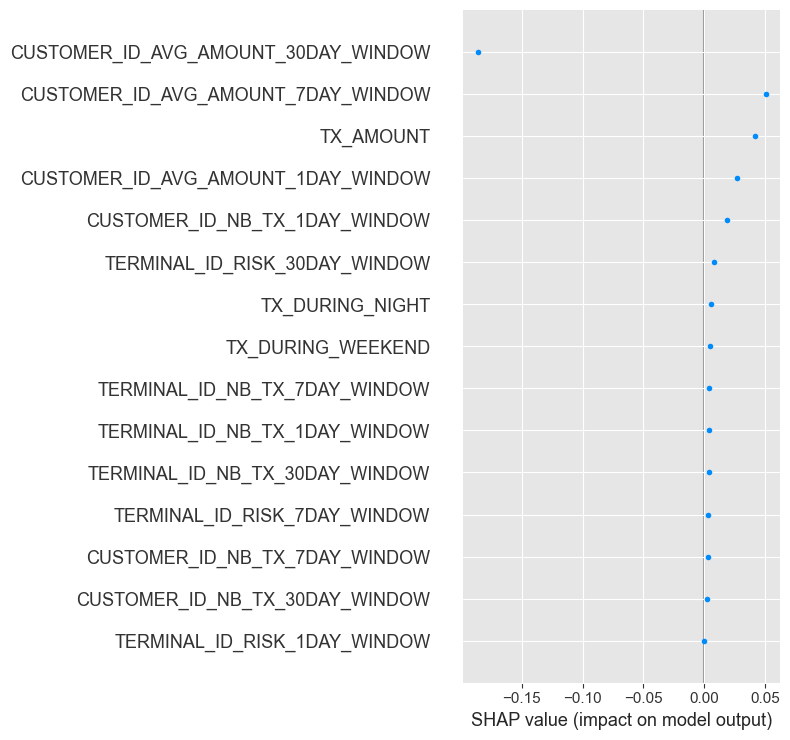

t = 1
[ 0.02141421 -0.00218769  0.01360109  0.02345107 -0.02037624  0.00587997
 -0.04681673  0.00300137  0.12574603  0.04599747  0.00058436 -0.10298721
 -0.00350988 -0.10536703 -0.00359303]


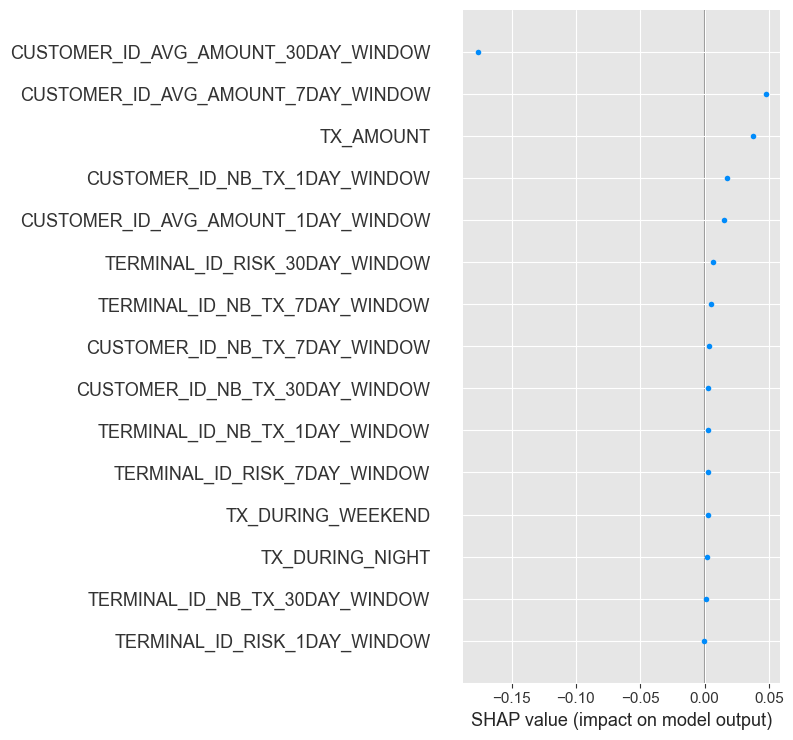

t = 2
[ 0.02540575 -0.00202463  0.01443064  0.01573675 -0.03299584  0.01179656
 -0.04752535  0.0045189   0.0422011   0.032187    0.00142789  0.10278696
 -0.0018995  -0.03220493 -0.00804308]


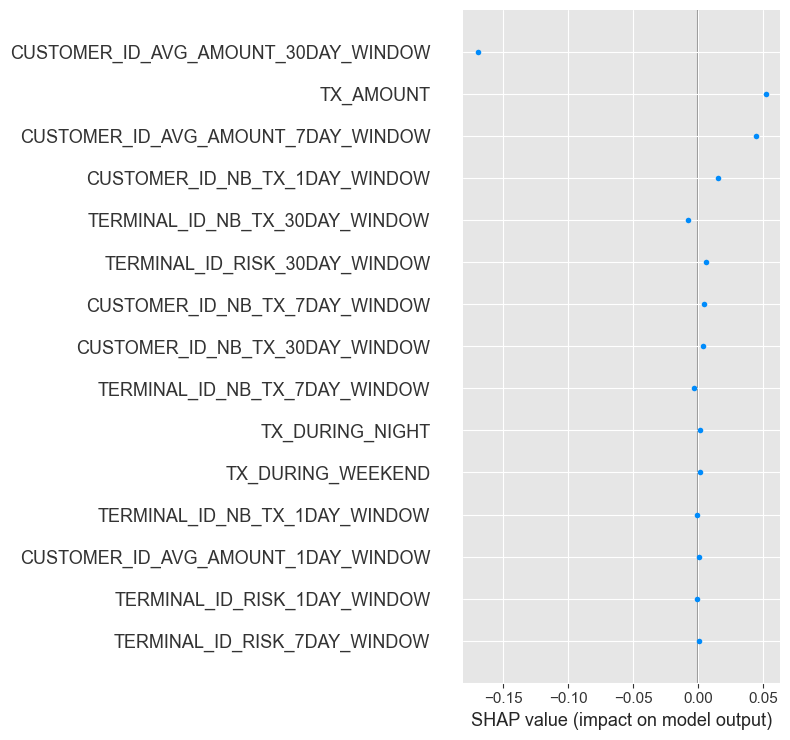

t = 3
[ 0.00097475  0.01927082  0.00413423  0.03102851  0.04794875  0.00509666
 -0.29329205  0.00217378  0.3860926   0.03139553 -0.00053435  0.00148789
  0.00040831 -0.04582686  0.008336  ]


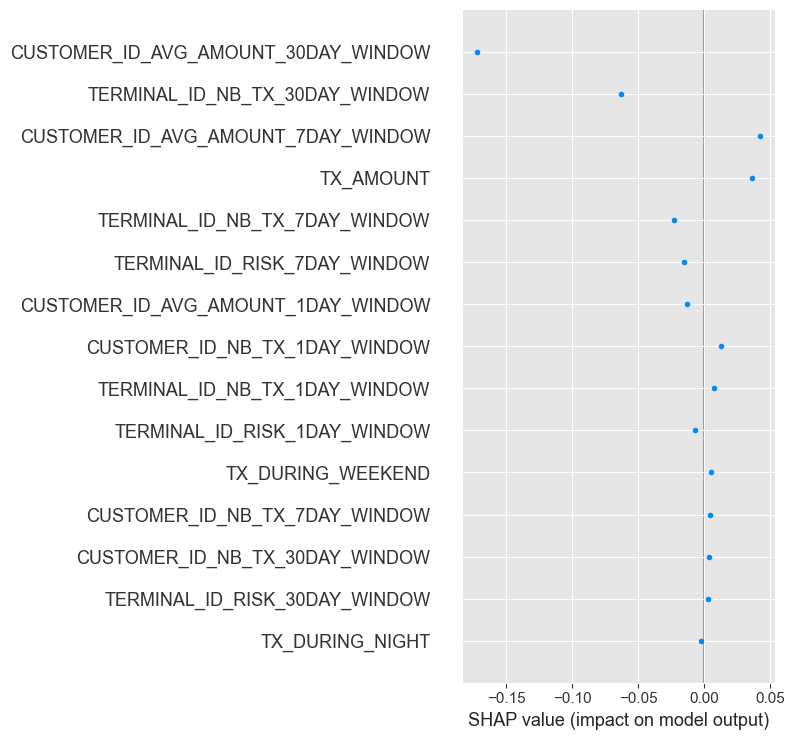

t = 4
[-0.00304717 -0.01902994 -0.02354938 -0.01369219  0.03175525 -0.0042596
 -0.28081584  0.00699133  1.07428288  0.19977653 -0.00609629 -0.38790753
 -0.09980675  0.03719191  0.04649467]


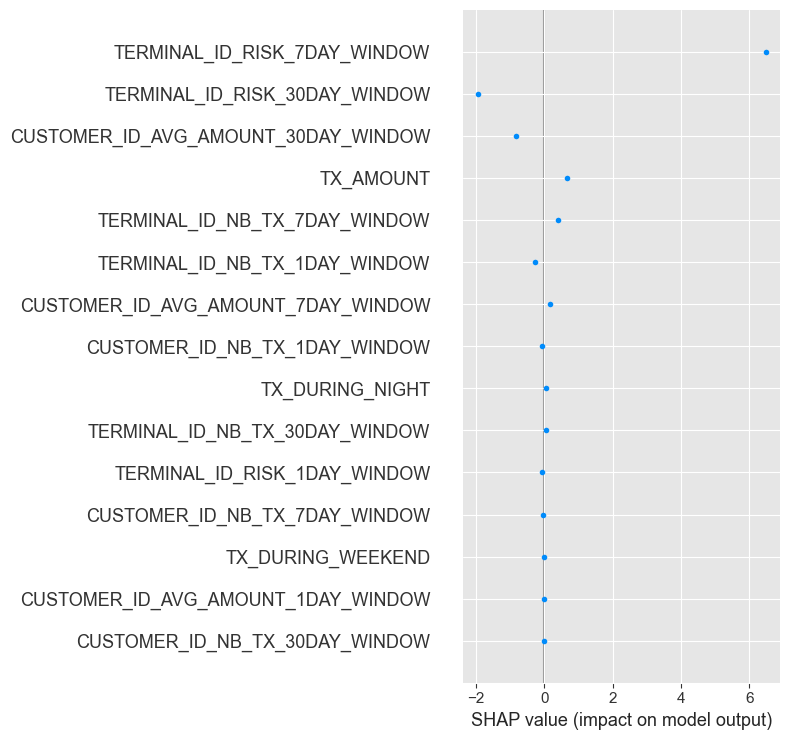

In [74]:
for t in range(seq_len):
    print('t =', t)
    print(np.array([el[t] for el in shap_values[0].tolist()]))
    shap.summary_plot(np.array([el[t] for el in selected_outlier_shap_values.tolist()]).reshape(1, -1),
                    feature_names=input_features)
    
# feature name - feature index mapping seems to be correct, unfortunately names per timestamp are not in the same order

##### Summary plot timesteps aggregated

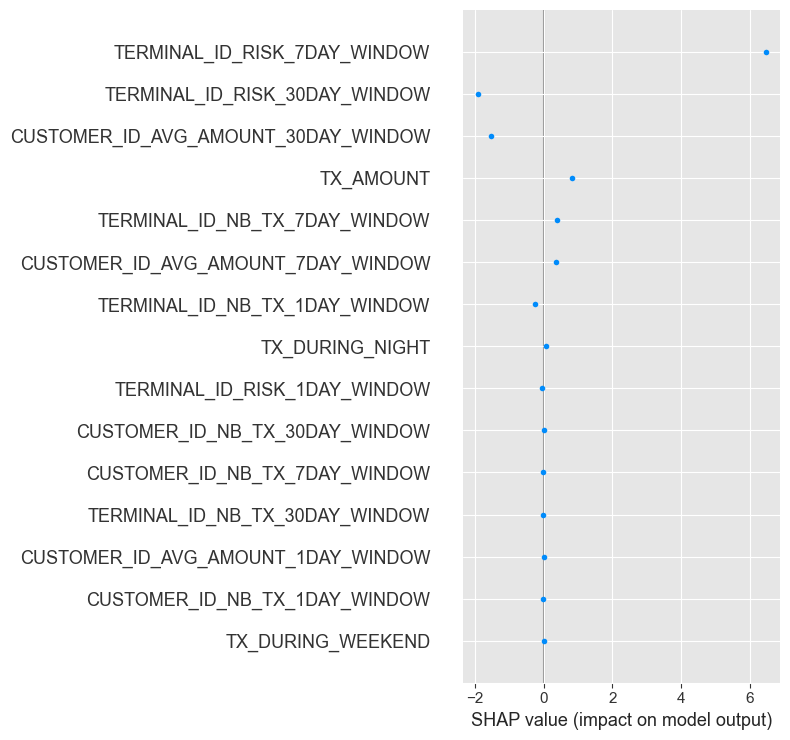

In [75]:
shap.summary_plot(np.sum(selected_outlier_shap_values, axis=1).reshape(1, -1),
                feature_names=input_features)

##### Force plot per timestep

t = 0
[-0.05010257  0.00612949  0.01240113  0.04080689 -0.02012819  0.00472299
 -0.04635067  0.00266912  0.12991691  0.00385718  0.00108774  0.07454702
 -0.00080157 -0.00980259 -0.0025015 ]


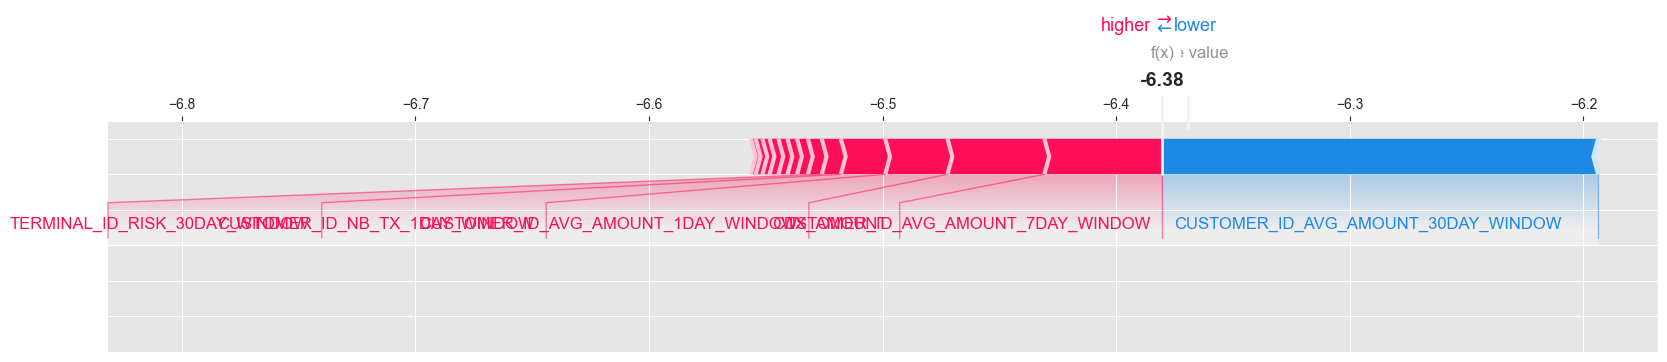

t = 1
[ 0.02141421 -0.00218769  0.01360109  0.02345107 -0.02037624  0.00587997
 -0.04681673  0.00300137  0.12574603  0.04599747  0.00058436 -0.10298721
 -0.00350988 -0.10536703 -0.00359303]


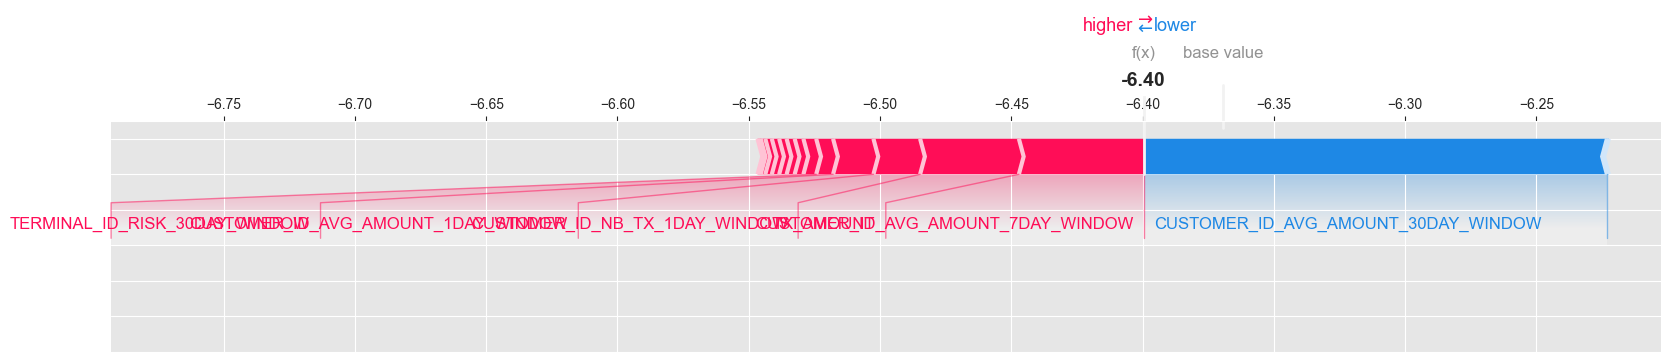

t = 2
[ 0.02540575 -0.00202463  0.01443064  0.01573675 -0.03299584  0.01179656
 -0.04752535  0.0045189   0.0422011   0.032187    0.00142789  0.10278696
 -0.0018995  -0.03220493 -0.00804308]


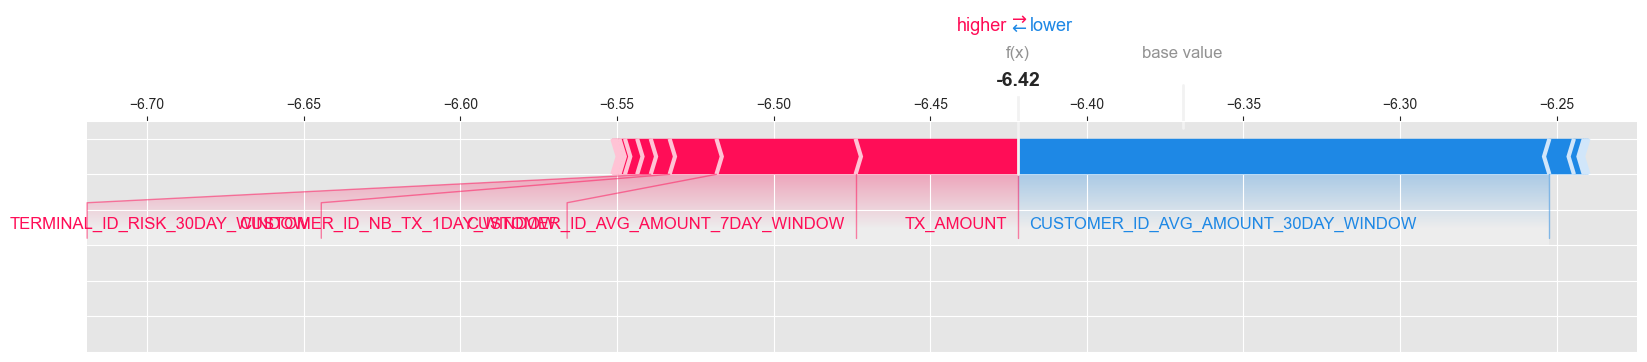

t = 3
[ 0.00097475  0.01927082  0.00413423  0.03102851  0.04794875  0.00509666
 -0.29329205  0.00217378  0.3860926   0.03139553 -0.00053435  0.00148789
  0.00040831 -0.04582686  0.008336  ]


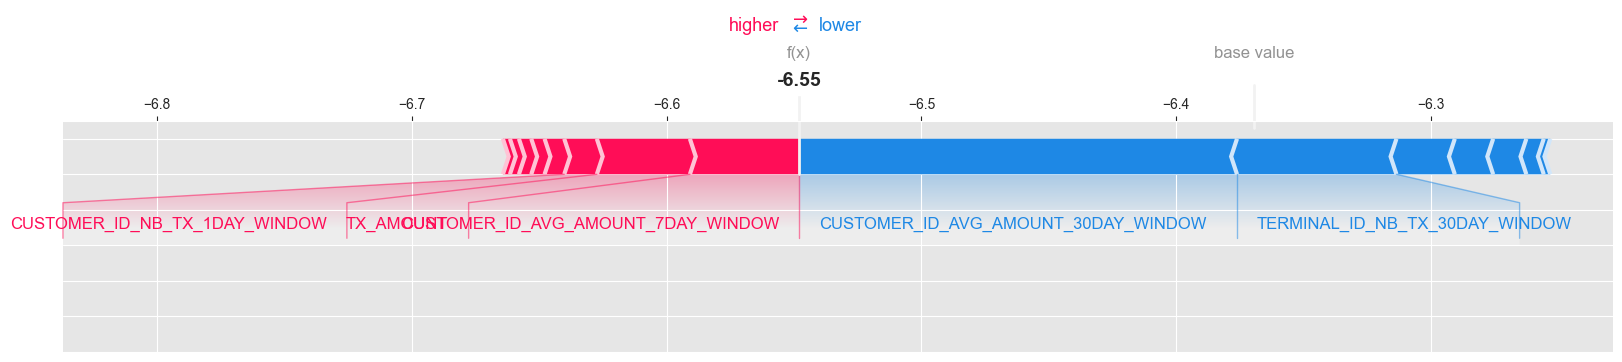

t = 4
[-0.00304717 -0.01902994 -0.02354938 -0.01369219  0.03175525 -0.0042596
 -0.28081584  0.00699133  1.07428288  0.19977653 -0.00609629 -0.38790753
 -0.09980675  0.03719191  0.04649467]


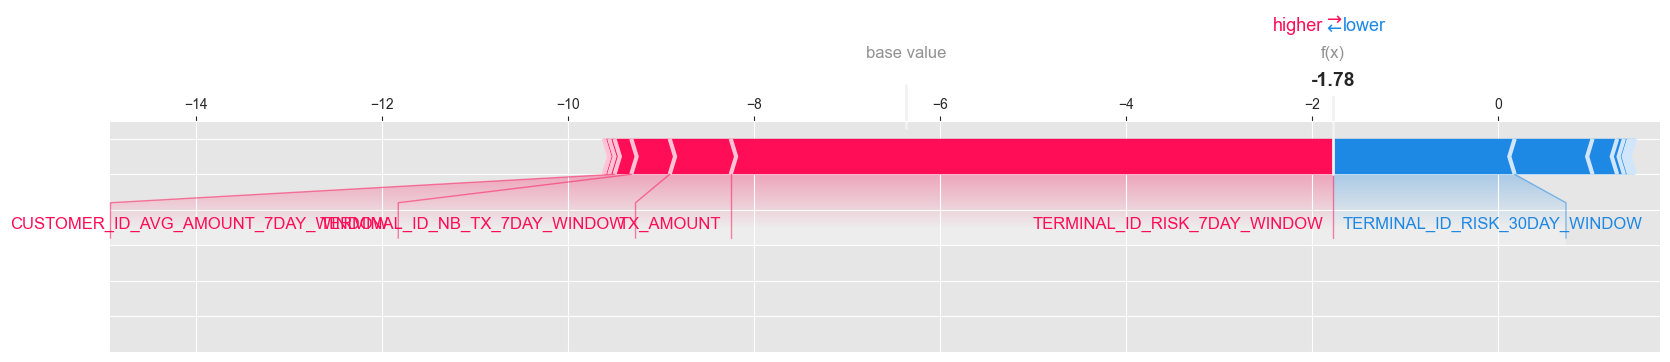

In [76]:
for t in range(seq_len):
    print('t =', t)
    print(np.array([el[t] for el in shap_values[0].tolist()]))
    shap.plots.force(explainer.expected_value[0],
                    np.array([el[t] for el in selected_outlier_shap_values.tolist()]),
                    feature_names=input_features,
                    matplotlib=True,
                    )   
                    # link='logit') # makes all plots look the same

##### Force plot timesteps aggregated

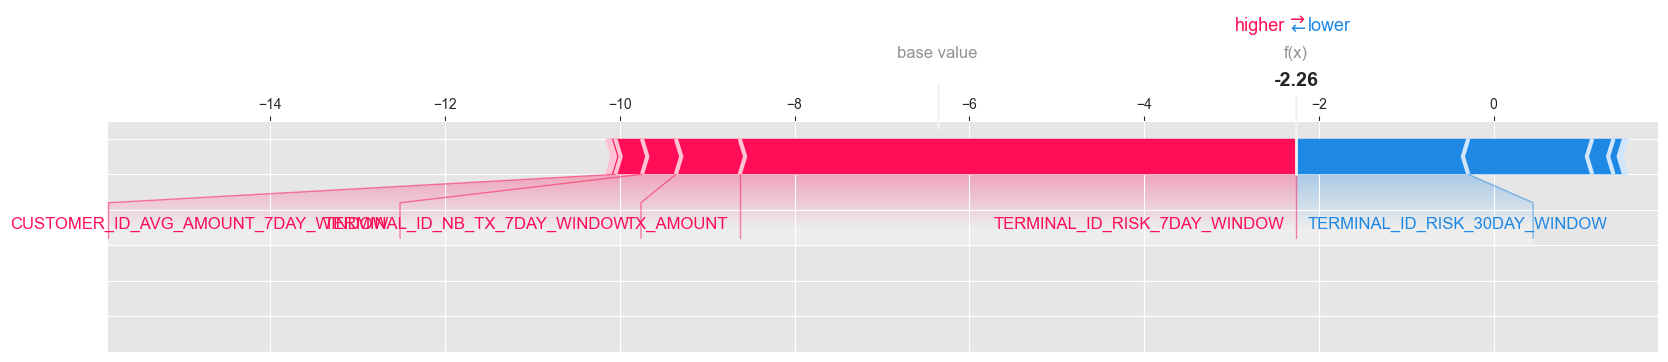

In [ ]:
shap.plots.force(explainer.expected_value[0],
                  np.sum(selected_outlier_shap_values, axis=1),
                  feature_names=input_features,
                  matplotlib=True)